# Run a PESTPP-IES experiment

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pyemu
import matplotlib.pyplot as plt
import helpers

In [2]:
# the existing dataset
org_working_d = "model_and_pest_files"
# the new dataset for this experiment
working_d = "model_and_pest_file_exp1"
# the master ies dir that will be created
master_dir = "master_ies"
# number of parallel workers
num_workers = 15

In [3]:
assert os.path.exists(org_working_d)
if os.path.exists(working_d):
    shutil.rmtree(working_d)
shutil.copytree(org_working_d, working_d)

'model_and_pest_file_exp1'

load the control file and check that it has had weights set

In [4]:
pst = pyemu.Pst(os.path.join(working_d, "pest.pst"))
assert pst.nobs > pst.nnz_obs
assert pst.nnz_obs > 0

Modify any ies settings

In [5]:
pst.control_data.noptmax = 3
pst.pestpp_options["ies_num_reals"] = 50
pst.pestpp_options["ies_bad_phi_sigma"] = 1.75
# pst.pestpp_options["ies_n_iter_reinflate"] = [2, 999]
# pst.pestpp_options["ies_reinflate_num_reals"] = [50, -50]
# pst.pestpp_options["ies_multimodal_alpha"] = 0.99
# pst.pestpp_options.pop("ies_obs_en",None)
# pst.pestpp_options["ies_no_noise"] = True

pst.pestpp_options

{'ies_par_en': 'prior.csv',
 'ies_obs_en': 'noise.csv',
 'ies_phi_factor_file': 'phi_facs.csv',
 'ies_num_reals': 50,
 'ies_bad_phi_sigma': 1.75}

In [6]:
pst.write(os.path.join(working_d, "pest.pst"), version=2)

noptmax:3, npar_adj:1066, nnz_obs:5616


run PESTPP-IES

In [7]:
if os.path.exists(master_dir):
    shutil.rmtree(master_dir)
os.makedirs(master_dir)
pyemu.os_utils.start_workers(
    working_d,
    "pestpp-ies",
    "pest.pst",
    num_workers=num_workers,
    worker_root=master_dir,
    master_dir=master_dir,
)

2026-01-14 08:59:44,318 - MainProcess - INFO - Reserved port 4796 for process 7582




             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team

...processing command line: ' pestpp-ies pest.pst /h :4796'
...using panther run manager in master mode using port 4796


version: 5.2.25
binary compiled on Jan  6 2026 at 12:27:13
using control file: "pest.pst"
in directory: "/Users/jwhite/Dev/modflow-pest-tampa-2026/exercises/notebooks/master_ies"
on host: "macminiller.local"
on a(n) apple operating system
with release configuration
started at 01/14/26 08:59:44

processing control file pest.pst
parameter warning: 1 parameters are at upper bound


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     

Process and plot the results.  Choose the iteration to use as the "posterior"; if `noptmax` is `None`, the final iteration is used

In [8]:
noptmax = None

This creates a multi-page pdf in the master dir

In [9]:
helpers.plot_ies_timeseries(master_dir, noptmax=noptmax)

Plot some property realizations

In [10]:
tags = [
    "npf-k-layer1",
    "npf-k-layer5",
    "npf-k33-layer3",
    "sto-ss-layer1",
    "sto-sy-layer1",
]

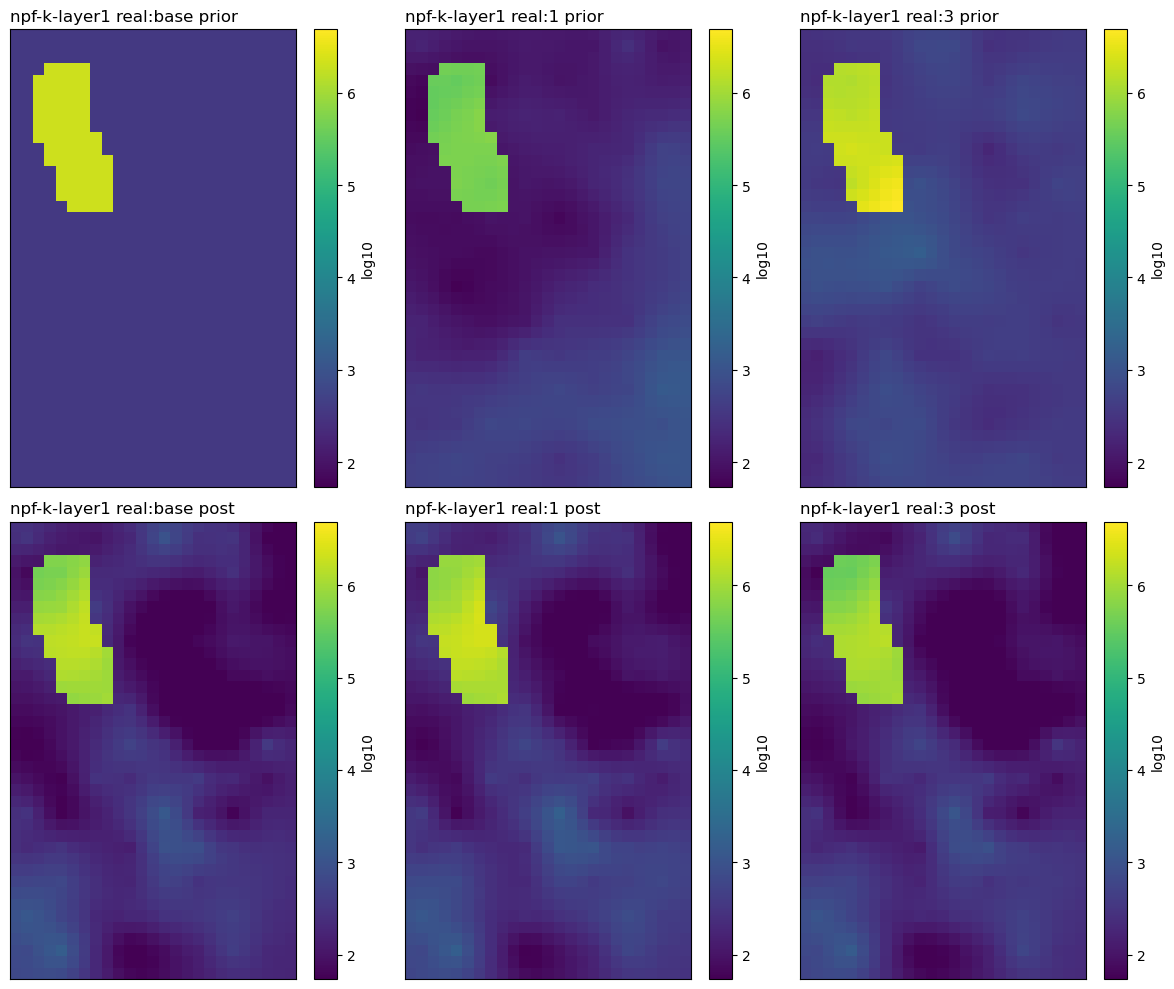

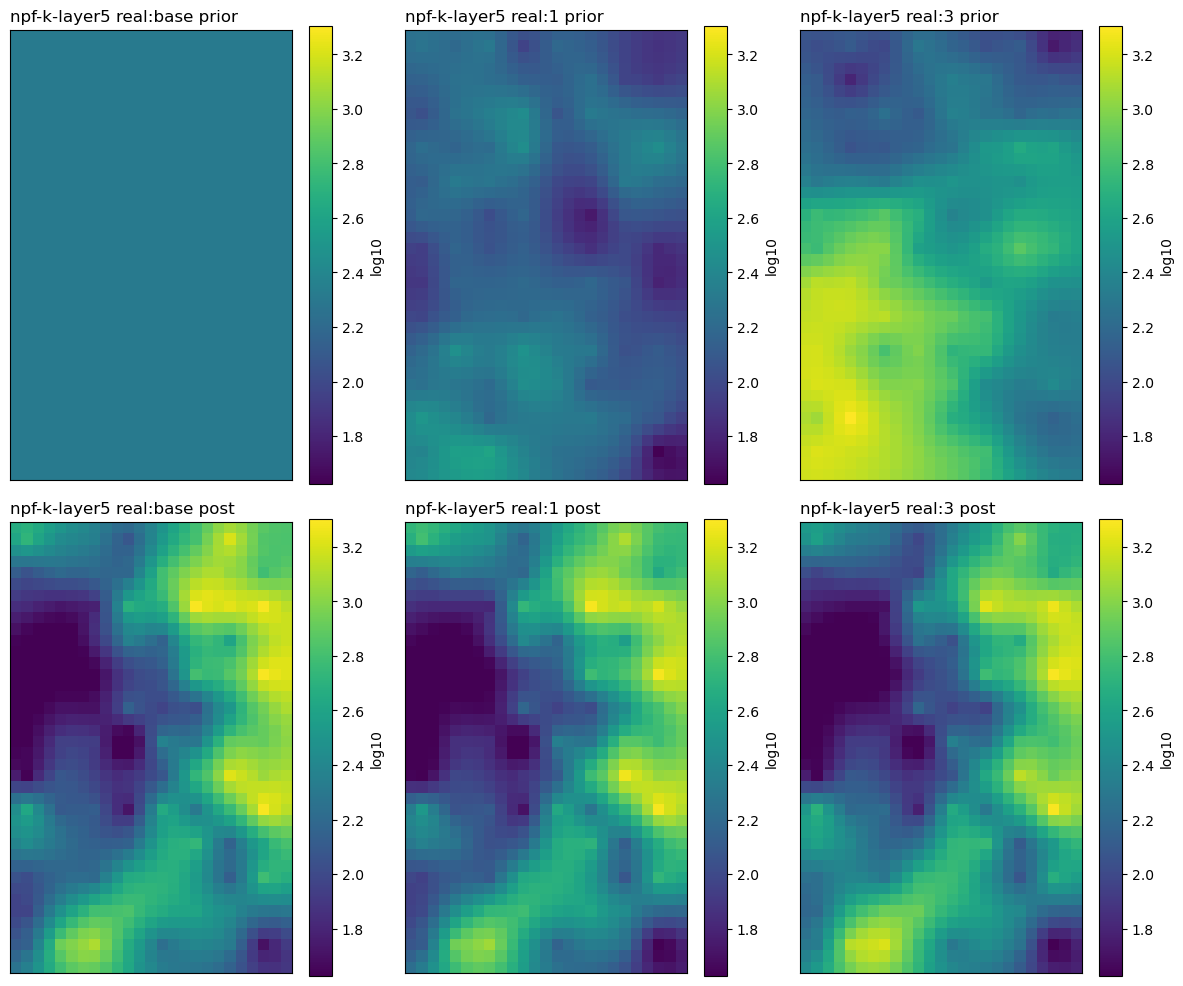

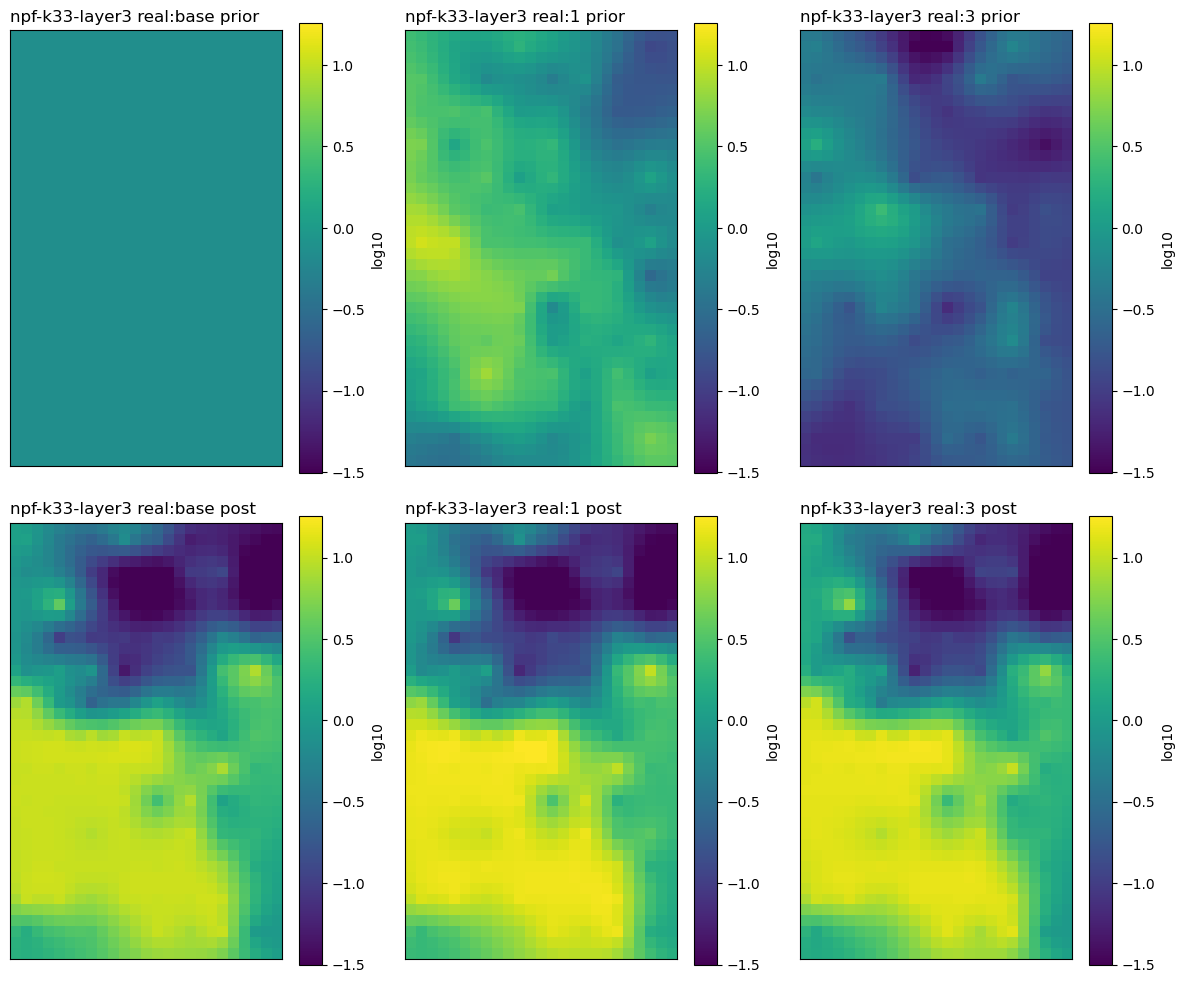

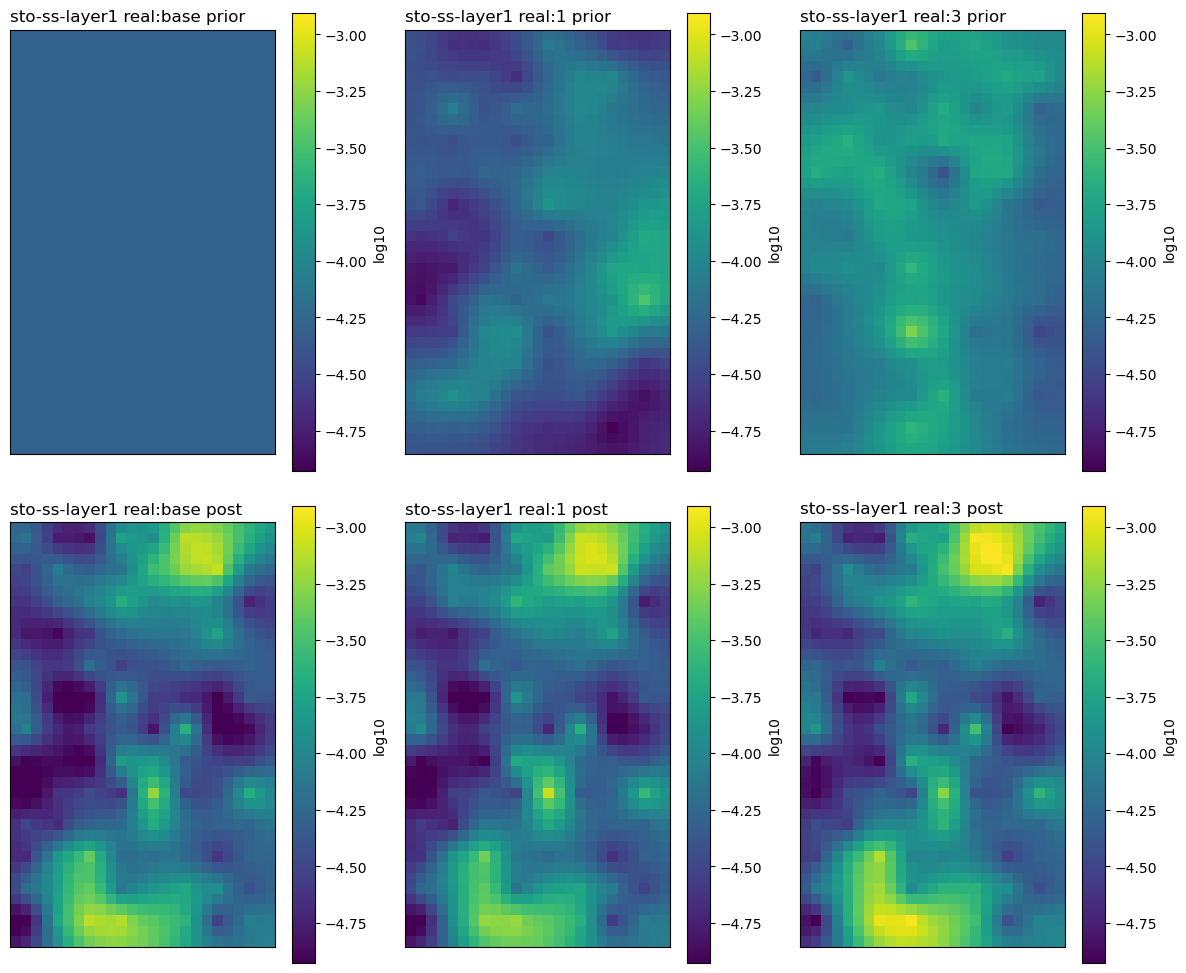

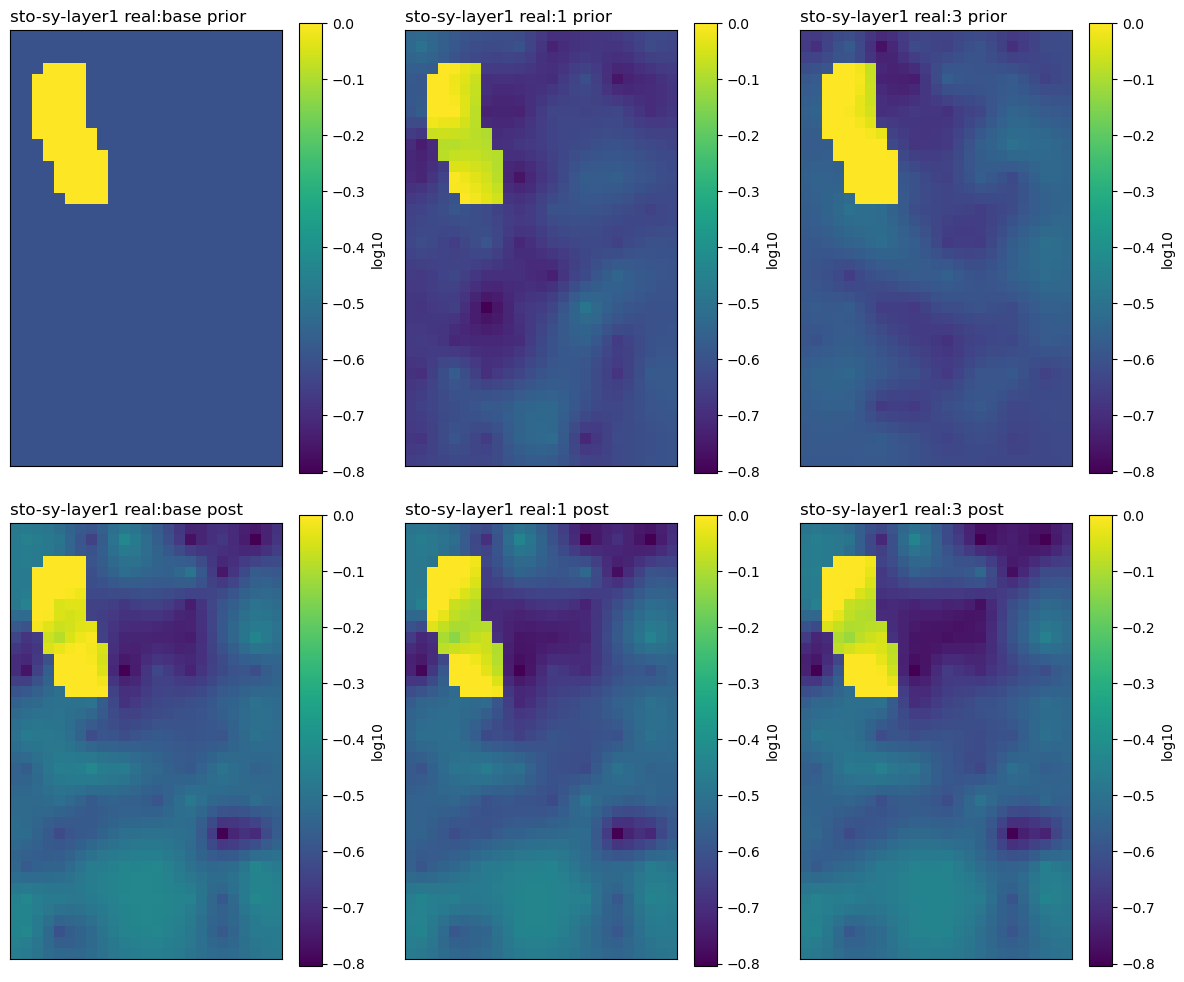

In [11]:
for tag in tags:
    helpers.plot_ies_properties(master_dir, tag, noptmax=noptmax)

Plot the prior and posterior forecast histograms:

['lake-stage', 'riv-swgw']


([<Figure size 800x600 with 3 Axes>, <Figure size 800x600 with 3 Axes>],
 array([<Axes: title={'left': 'riv-swgw hist-mean'}>,
        <Axes: title={'left': 'riv-swgw pred-mean'}>,
        <Axes: title={'left': 'riv-swgw diff-mean'}>], dtype=object))

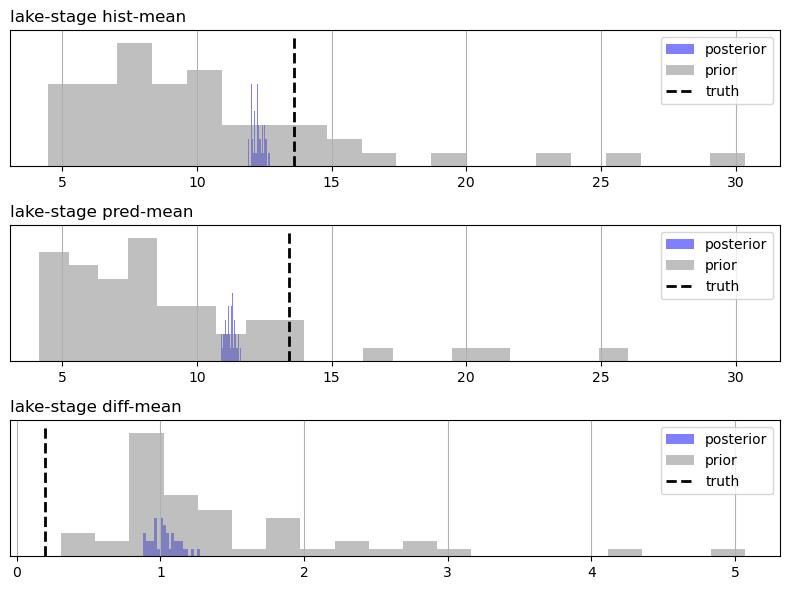

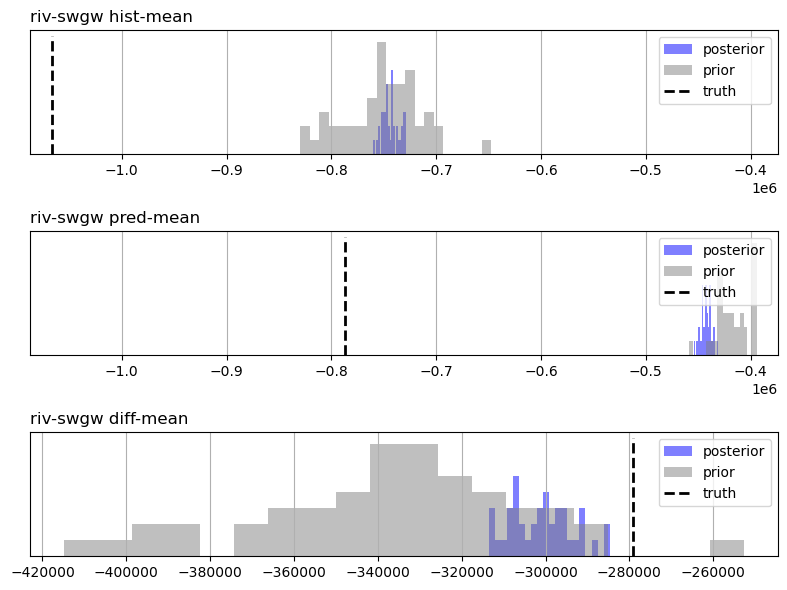

In [12]:
helpers.plot_ies_forecasts(master_dir, noptmax=noptmax, include_t=True)

Explore other ies results via the `Pst.ies` handler:

In [13]:
pst = pyemu.Pst(os.path.join(master_dir, "pest.pst"))

Plot the `actual` and `meas`ured phi sequence across iterations

In [14]:
pm, pa = pst.ies.phiactual, pst.ies.phimeas

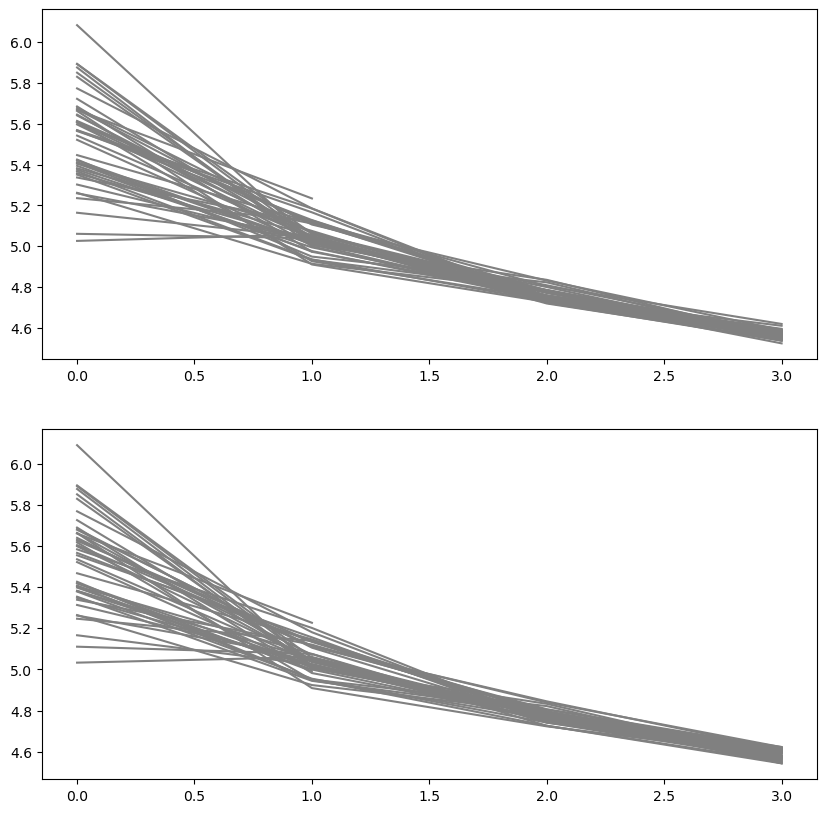

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
vals = np.log10(pm.iloc[:, 6:].values)
ivals = pm.iteration.values
_ = [axes[0].plot(ivals, vals[:, i], "0.5") for i in range(vals.shape[1])]
vals = np.log10(pa.iloc[:, 6:].values)
ivals = pa.iteration.values
_ = [axes[1].plot(ivals, vals[:, i], "0.5") for i in range(vals.shape[1])]

Visualize the parameter change summary across iterations

1
2
3


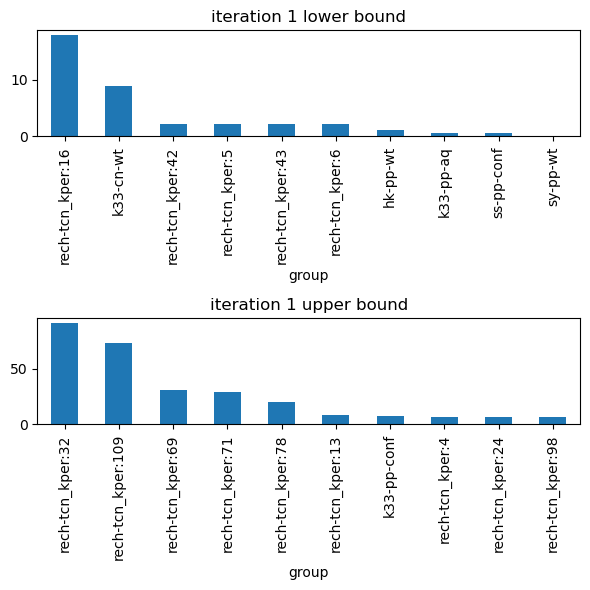

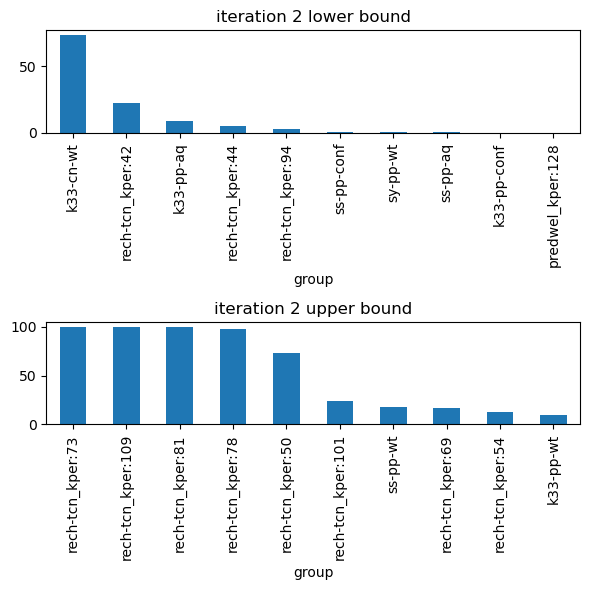

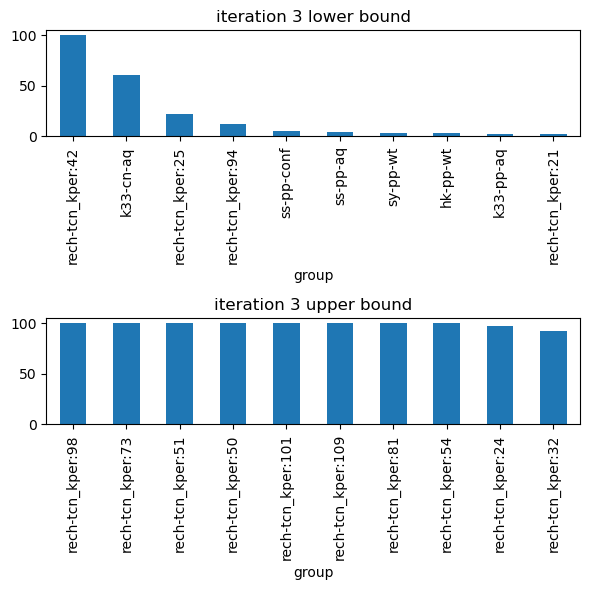

In [16]:
for i in pst.ies.pcs.index.get_level_values(0).unique():
    print(i)
    lbnd = pst.ies.pcs.loc[i, "percent_at_near_lbound"]
    ubnd = pst.ies.pcs.loc[i, "percent_at_near_ubound"]
    fig, axes = plt.subplots(2, 1, figsize=(6, 6))
    lbnd.sort_values(inplace=False, ascending=False).iloc[:10].plot(
        kind="bar", ax=axes[0]
    )
    ubnd.sort_values(inplace=False, ascending=False).iloc[:10].plot(
        kind="bar", ax=axes[1]
    )
    axes[0].set_title("iteration {0} lower bound".format(i))
    axes[1].set_title("iteration {0} upper bound".format(i))
    plt.tight_layout()